In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder,StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# !pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier, XGBRegressor, plot_importance


from tabulate import tabulate
import seaborn as sns
import shap
import lime

In [3]:
# 1. read CSV
df = pd.read_csv('/content/drive/MyDrive/XAI_DATA/Merged.csv',encoding='utf-8')

# 2. show the sample data
# print("data sample：")
# print(df.head())

# 3. basic info
# print("\nbasic info：")
# print(df.describe(include='all'))

# handle NaN
print(df.info())
features=df.columns.tolist()
print(features)
results = []
for col in df.columns:
  nunique = df[col].nunique(dropna=False)
  na_count = df[col].isna().sum()
  sample_values = df[col].dropna().sample(min(3, len(df)), replace=True).tolist()

  results.append({
            'Column': col,
            'Type': df[col].dtype,
            'Unique Values': nunique,
            'Missing Values': na_count,
            'Sample Values': sample_values[:3]
        })
print(tabulate(
        [(r['Column'], r['Type'], r['Unique Values'],
         f"{r['Missing Values']:,}", str(r['Sample Values']))
        for r in results],
        headers=['column', 'type', 'unique', 'missing', 'sample'],
        tablefmt='grid',
        numalign="right"
    ))

# object
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Object（{len(object_cols)}）：\n{object_cols}")

analysis_report = pd.DataFrame({
        'column': object_cols,
        'unique': [df[col].nunique() for col in object_cols],
        'Nan': [df[col].isnull().sum() for col in object_cols],
        'Nan rate': [df[col].isnull().mean().round(4) for col in object_cols],
        'frequency': [df[col].mode()[0] if not df[col].empty else np.nan for col in object_cols],
        'frequency rate': [round(df[col].value_counts(normalize=True).iloc[0], 4) for col in object_cols],
        'sample': [df[col].dropna().iloc[0] if not df[col].dropna().empty else np.nan for col in object_cols]
})

print("\nObject：")
display(analysis_report.sort_values('unique', ascending=False))

for col in object_cols:
    value_counts = df[col].value_counts(dropna=False)
    unique_count = len(value_counts)

    print(f"\n=== column【{col}】 ===")
    print(f"unique{unique_count}")
    print(value_counts.head(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716863 entries, 0 to 716862
Data columns (total 88 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    716863 non-null  int64  
 1   Flow ID                       716863 non-null  object 
 2    Source IP                    716863 non-null  object 
 3    Source Port                  716863 non-null  int64  
 4    Destination IP               716863 non-null  object 
 5    Destination Port             716863 non-null  int64  
 6    Protocol                     716863 non-null  int64  
 7    Timestamp                    716863 non-null  object 
 8    Flow Duration                716863 non-null  int64  
 9    Total Fwd Packets            716863 non-null  int64  
 10   Total Backward Packets       716863 non-null  int64  
 11  Total Length of Fwd Packets   716863 non-null  float64
 12   Total Length of Bwd Packets  716863 non-nul

,column,unique,Nan,Nan rate,frequency,frequency rate,sample
3,Timestamp,716804,0,0.0,2018-12-01 09:31:04.166453,0.0000,2018-12-01 11:06:17.494296
0,Flow ID,682389,0,0.0,192.168.50.253-224.0.0.5-0-0-0,0.0009,172.16.0.5-192.168.50.1-548-27125-17
2,Destination IP,598,0,0.0,192.168.50.1,0.9203,192.168.50.1
1,Source IP,550,0,0.0,172.16.0.5,0.9201,172.16.0.5
4,SimillarHTTP,360,0,0.0,0,0.9971,0
5,Label,12,0,0.0,DrDoS_DNS,0.0837,DrDoS_DNS



=== column【Flow ID】 ===
unique682389
Flow ID
192.168.50.253-224.0.0.5-0-0-0                639
192.168.50.254-224.0.0.5-0-0-0                633
8.0.6.4-8.6.0.1-0-0-0                         344
192.168.50.7-52.173.24.17-50107-443-6         160
255.255.255.255-0.0.0.0-67-68-17              154
192.168.50.1-4.2.2.4-46873-53-17               42
192.168.50.255-192.168.50.8-138-138-17         40
192.168.50.1-8.8.8.8-46873-53-17               39
192.168.50.7-23.194.142.213-51461-443-6        30
192.168.50.6-23.194.110.93-58295-443-6         30
192.168.50.8-23.194.110.93-60155-443-6         29
192.168.50.8-239.255.255.250-50841-1900-17     28
192.168.50.8-23.194.142.213-59389-443-6        27
192.168.50.8-23.194.142.213-59390-443-6        26
192.168.50.7-125.56.201.105-51948-80-6         22
192.168.50.7-52.80.102.242-51458-443-6         22
192.168.50.7-72.21.91.29-51965-80-6            21
192.168.50.6-125.56.201.105-58160-80-6         21
172.217.6.194-192.168.50.8-443-60122-6         21
192.

In [4]:
df['Flow Bytes/s'] = df['Flow Bytes/s'].replace([np.inf, -np.inf], 1e11)
df[' Flow Packets/s'] = df[' Flow Packets/s'].replace([np.inf, -np.inf], 1e8)
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Object（{len(object_cols)}）：\n{object_cols}")
unique_columns=[item['Column'] for item in results if item['Unique Values'] == 1]
print(unique_columns)
drop_columns=unique_columns+['Unnamed: 0','Flow ID',' Source IP',' Destination IP',' Timestamp','SimillarHTTP']
df_cleaned = df.drop(drop_columns, axis=1)
df_cleaned = df_cleaned.dropna(axis=0)
print(df_cleaned.info())

Object（6）：
['Flow ID', ' Source IP', ' Destination IP', ' Timestamp', 'SimillarHTTP', ' Label']
[' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', 'FIN Flag Count', ' PSH Flag Count', ' ECE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
<class 'pandas.core.frame.DataFrame'>
Index: 703096 entries, 0 to 716861
Data columns (total 70 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Source Port                  703096 non-null  int64  
 1    Destination Port             703096 non-null  int64  
 2    Protocol                     703096 non-null  int64  
 3    Flow Duration                703096 non-null  int64  
 4    Total Fwd Packets            703096 non-null  int64  
 5    Total Backward Packets       703096 non-null  int64  
 6   Total Length of Fwd Packets   703096 non-null  float64
 7    Tot

In [5]:
features=df_cleaned.columns.tolist()
features.remove(' Label')
print(features)
X = df_cleaned[features]
y = df_cleaned[' Label']
le = LabelEncoder()
y = le.fit_transform(y)

[' Source Port', ' Destination Port', ' Protocol', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', ' SYN Flag Count', ' RST Flag Count', ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count', ' Down/Up Ratio', ' Average Packet 

In [ ]:
#Tree (XGBoost/LightGBM/CatBoost/scikit-learn/pyspark models)

def tree_explainer(X,model):
  explainer = shap.Explainer(model)
  shap_values = explainer(X)
  # visualize the first prediction's explanation
  shap.plots.waterfall(shap_values[0])
  # visualize the first prediction's explanation with a force plot
  shap.plots.force(shap_values[0])
  # visualize all the training set predictions
  shap.plots.force(shap_values[:500])
   # create a dependence scatter plot to show the effect of a single feature across the whole dataset
  shap.plots.scatter(shap_values[:, "Latitude"], color=shap_values)
  # summarize the effects of all the features
  shap.plots.beeswarm(shap_values)
  # take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs)
  shap.plots.bar(shap_values)
  return

def deep_explainer(x_train,x_test,model):
# select a set of background examples to take an expectation over
  background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
  e = shap.DeepExplainer(model, background)
  shap_values = e.shap_values(x_test[0:10])
# plot the feature attributions
  shap.force_plot(explainer.expected_value[0], shap_values[0], X_test[0])
  return

# Model agnostic example with KernelExplainer (explains any function)
def kernel_explainer(x_train,x_test,model):
  # use Kernel SHAP to explain test set predictions
  explainer = shap.KernelExplainer(model.predict_proba, X_train, link="logit")
  shap_values = explainer.shap_values(X_test, nsamples=100)
  # plot the SHAP values for the Setosa output of all instances
  shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")
  return



In [ ]:
import lime
import lime.lime_tabular

# 初始化LIME解释器
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=features,  # 替换为实际特征名列表
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# 解释单个样本（示例：测试集第一个错误预测）
sample_idx = error_mask.nonzero()[0][0]
exp = explainer.explain_instance(
    X_test_scaled[sample_idx],
    model.predict,
    num_features=10,
    top_labels=3
)

# 可视化解释
exp.show_in_notebook(show_table=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


After having a total view of the dataset, the next step will be using different ML model to build the detection system.
Here we choose different models:

1.   Decision Trees
2.   Random Forests

1.   Multilayer Perceptron
2.   DNN

1.   XGBoost






Test Accuracy: 0.73

Classification Report:
               precision    recall  f1-score   support

       BENIGN       1.00      0.99      0.99     17025
    DrDoS_DNS       0.61      0.39      0.48     18000
   DrDoS_LDAP       0.53      0.53      0.53     18000
  DrDoS_MSSQL       0.83      0.95      0.89     18000
    DrDoS_NTP       1.00      0.99      0.99     18000
DrDoS_NetBIOS       0.94      0.98      0.96     18000
   DrDoS_SNMP       0.63      0.84      0.72     18000
   DrDoS_SSDP       0.44      0.09      0.15     18000
    DrDoS_UDP       0.49      0.90      0.64     18000
          Syn       0.58      1.00      0.74     15708
         TFTP       0.96      0.86      0.91     17992
      UDP-lag       0.99      0.19      0.31     16204

     accuracy                           0.73    210929
    macro avg       0.75      0.73      0.69    210929
 weighted avg       0.75      0.73      0.69    210929



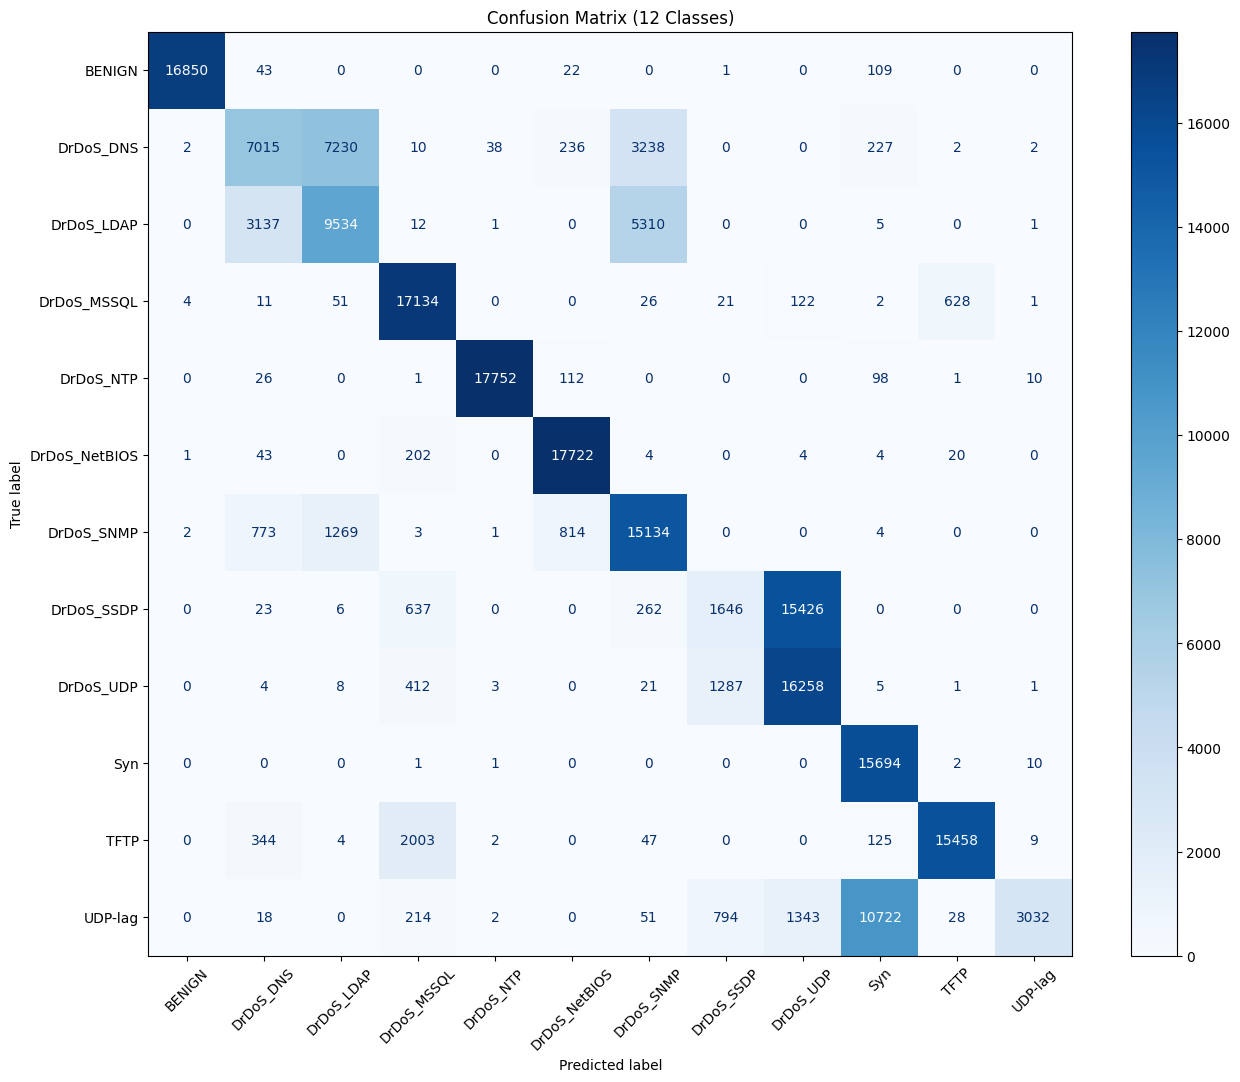


Top 10 Features:
 Source Port              0.237401
 Min Packet Length        0.145545
 Max Packet Length        0.136888
 Fwd Packet Length Max    0.134114
 Fwd Packet Length Min    0.129743
 Inbound                  0.106475
Flow Bytes/s              0.074985
 Idle Max                 0.015642
 Flow Duration            0.006143
 Fwd Header Length        0.005431
dtype: float64


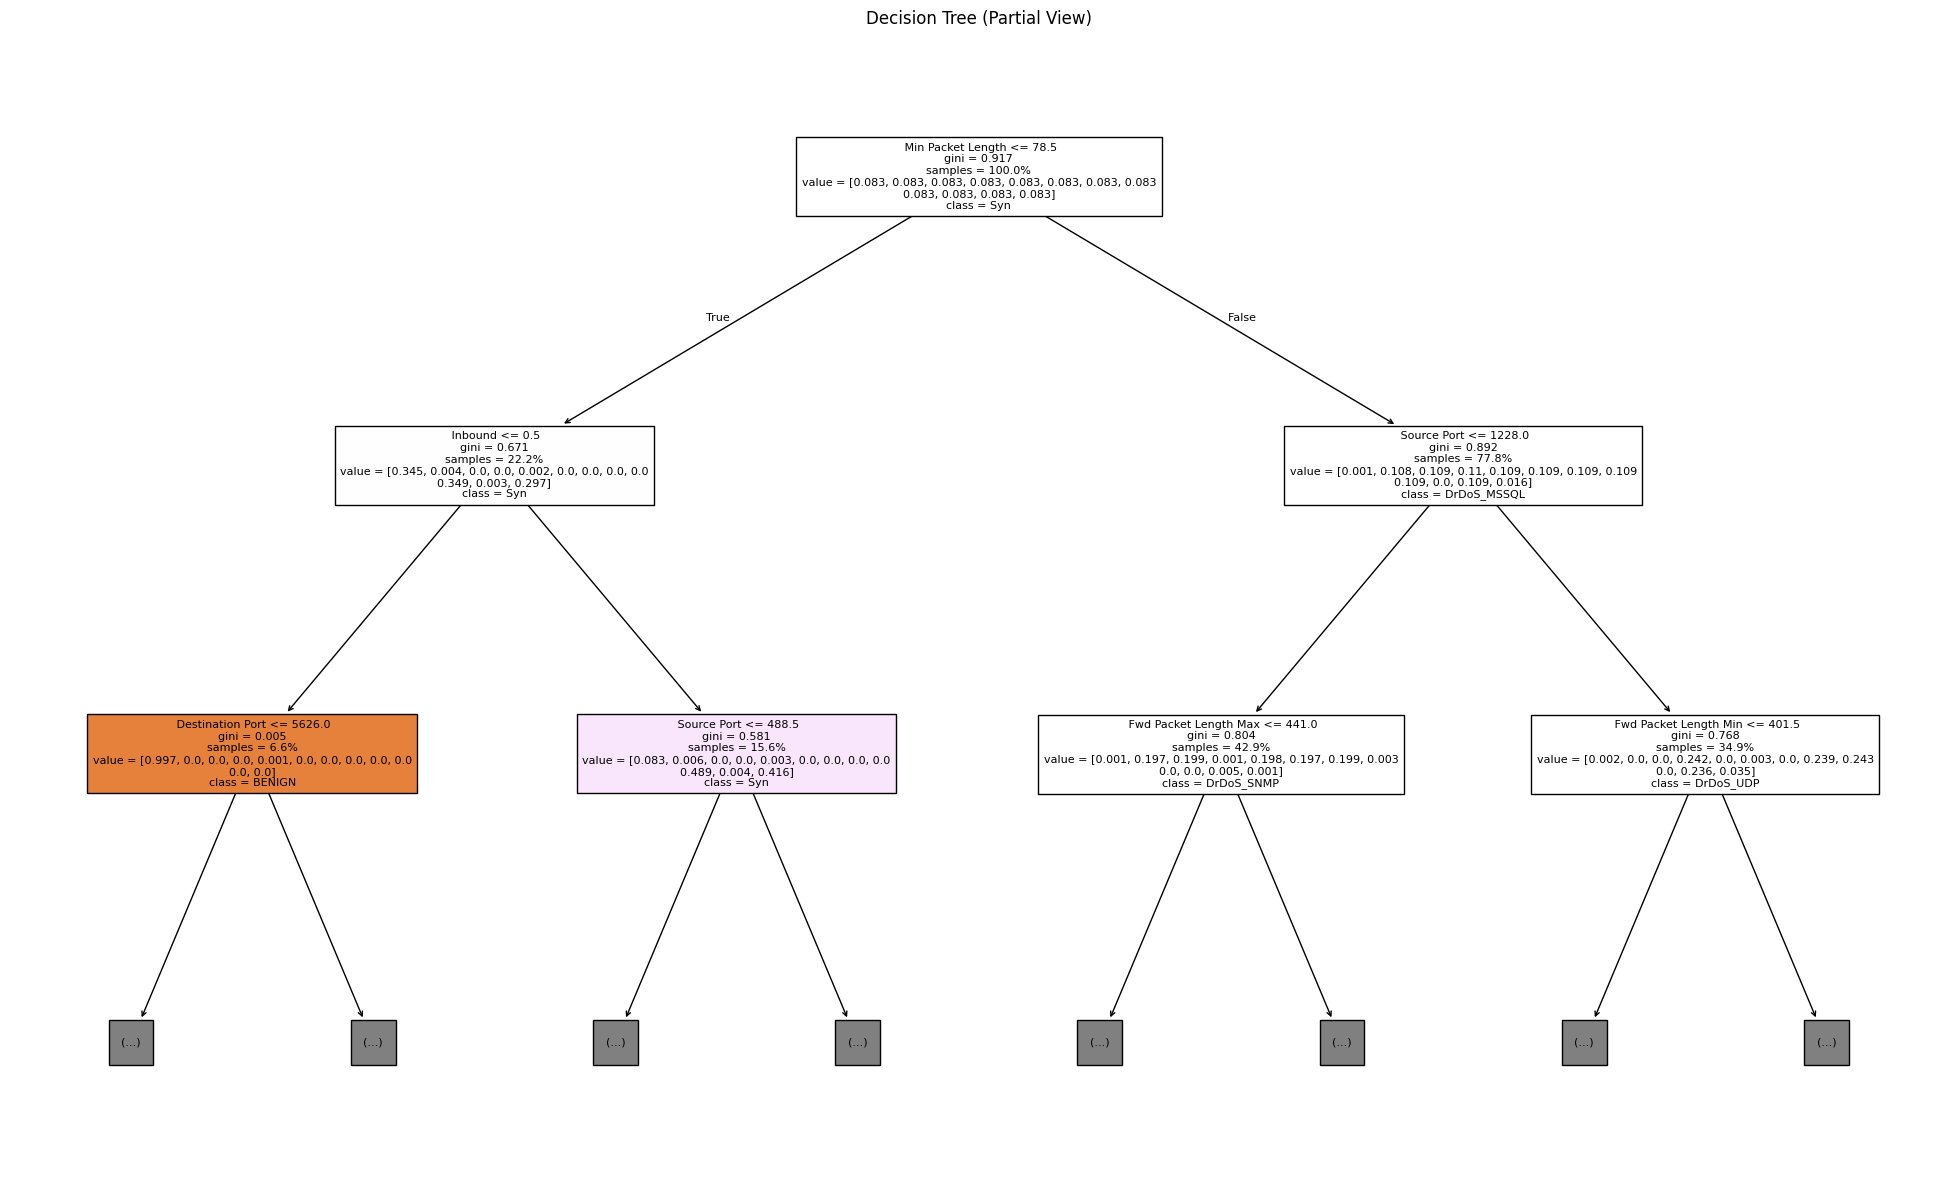

In [6]:
#DT

# divide data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

# train the model
clf.fit(X_train, y_train)

# prediction
y_pred = clf.predict(X_test)

# evaluation
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}\n")

class_names = le.classes_.tolist()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

fig, ax = plt.subplots(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (12 Classes)")
plt.show()

# feature importance
feature_importance = pd.Series(clf.feature_importances_, index=features)
feature_importance = feature_importance.sort_values(ascending=False)
print("\nTop 10 Features:")
print(feature_importance.head(10))

# plot
plt.figure(figsize=(25, 15))
# Ensure you are calling the correct plot_tree from sklearn.tree
plot_tree(
    clf,
    filled=True,
    feature_names=features,
    class_names=class_names,
    max_depth=2,
    fontsize=8,
    proportion=True
)
plt.title("Decision Tree (Partial View)")
plt.show()

In [9]:
print(X_test.columns.tolist())

[' Source Port', ' Destination Port', ' Protocol', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', ' SYN Flag Count', ' RST Flag Count', ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count', ' Down/Up Ratio', ' Average Packet 

In [ ]:
#XAI
# SHAP
explainer = shap.TreeExplainer(clf)
explanation = explainer(X_test)
shap_values = explanation.values  # 三维数组 (sample, feature, class)

# 全局
# plot by class
for k in range(n_classes):
    shap.summary_plot(shap_values[:, :, k], X_test, plot_type="bar", show=False)
    plt.title(f"Feature Importance for Class {k}")
    plt.show()

shap.summary_plot(shap_values[:, :, k], X_test, feature_names=feature_names)
# shap.dependence_plot("sepal_length", shap_values[:, :, 0], X_test, interaction_index="petal_width")

# local
# sample_idx = 5  # 选择样本
# class_idx = 0   # 选择类别
# shap.force_plot(
#     explainer.expected_value[class_idx],
#     shap_values[sample_idx, :, class_idx],
#     X_test.iloc[sample_idx],
#     feature_names=feature_names,
#     matplotlib=True
# )

# shap.waterfall_plot(
#     shap.Explanation(
#         values=shap_values[sample_idx, :, class_idx],
#         base_values=explainer.expected_value[class_idx],
#         data=X_test.iloc[sample_idx],
#         feature_names=feature_names
#     )
# )

Test Accuracy: 0.7630

Classification Report:
               precision    recall  f1-score   support

       BENIGN       1.00      1.00      1.00     17025
    DrDoS_DNS       0.76      0.51      0.61     18000
   DrDoS_LDAP       0.58      0.59      0.59     18000
  DrDoS_MSSQL       0.95      0.98      0.97     18000
    DrDoS_NTP       1.00      1.00      1.00     18000
DrDoS_NetBIOS       0.95      0.98      0.97     18000
   DrDoS_SNMP       0.66      0.86      0.75     18000
   DrDoS_SSDP       0.49      0.19      0.28     18000
    DrDoS_UDP       0.50      0.84      0.62     18000
          Syn       0.59      1.00      0.74     15708
         TFTP       1.00      0.99      1.00     17992
      UDP-lag       0.98      0.20      0.33     16204

     accuracy                           0.76    210929
    macro avg       0.79      0.76      0.74    210929
 weighted avg       0.79      0.76      0.74    210929



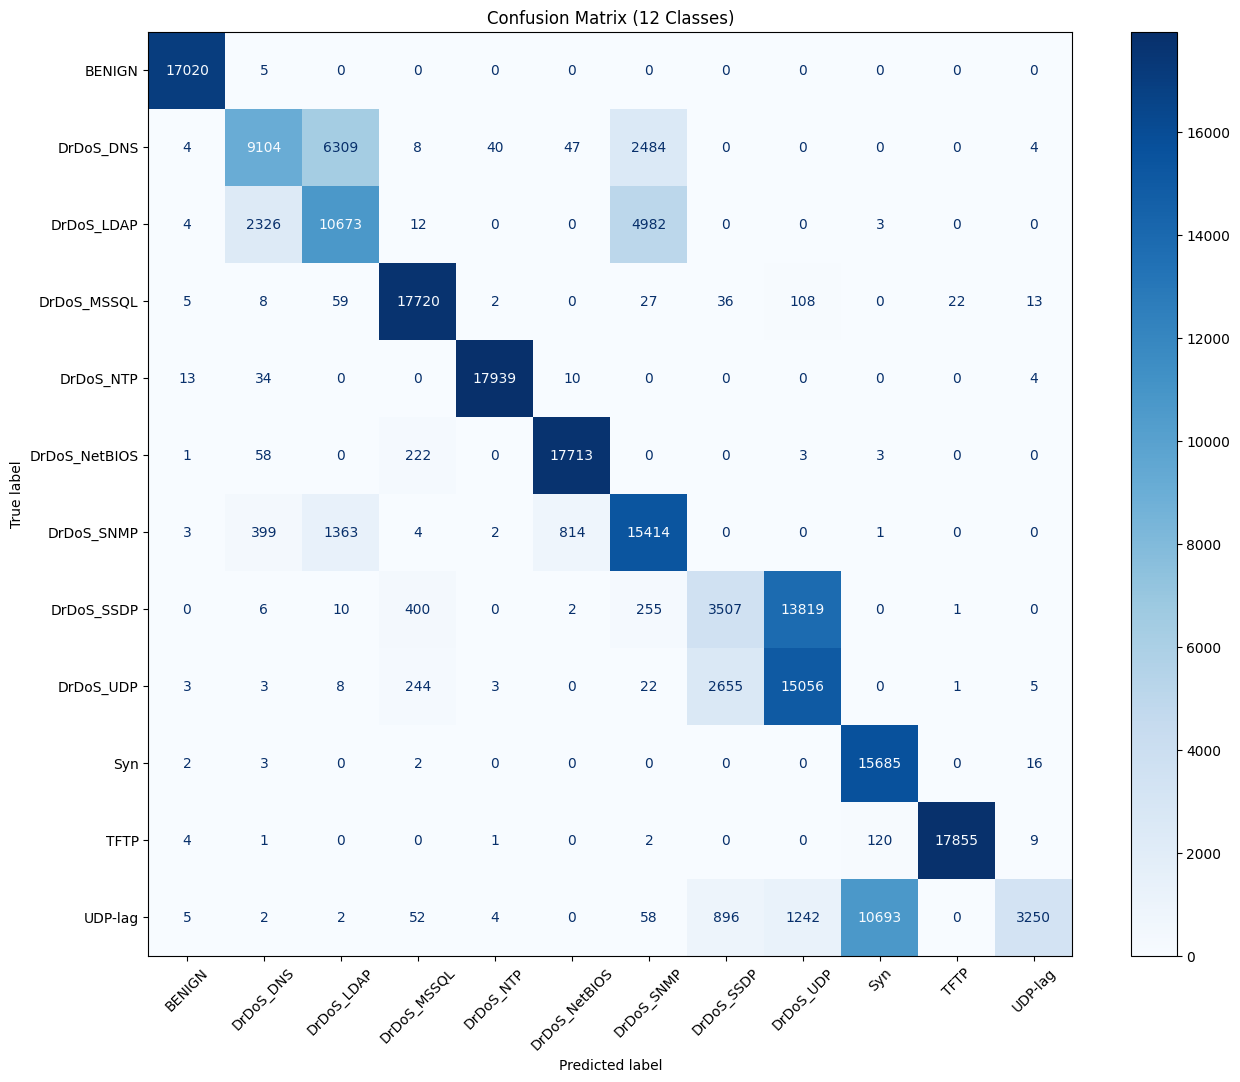

<ipython-input-9-2e205280e315>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20], palette="viridis")


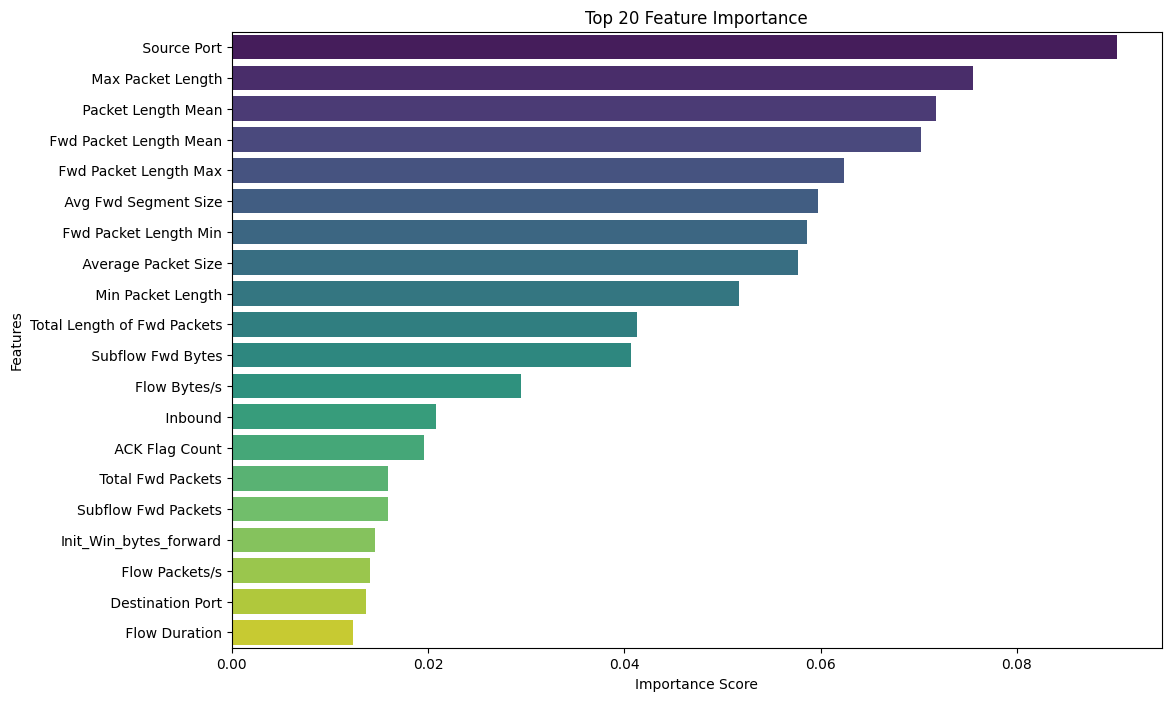

In [ ]:
#RF

rf_clf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# train
rf_clf.fit(X_train, y_train)

# prediction
y_pred = rf_clf.predict(X_test)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

class_names = le.classes_.tolist()
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

fig, ax = plt.subplots(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (12 Classes)")
plt.show()

# feature importance
feature_importance = pd.Series(
    rf_clf.feature_importances_,
    index=features
).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20], palette="viridis")
plt.title("Top 20 Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [ ]:
tree_explainer(X,rf_clf)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,996 (70.30 KB)

 Trainable params: 17,996 (70.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.6340 - loss: 0.8240 - val_accuracy: 0.7160 - val_loss: 0.5842
Epoch 2/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.7072 - loss: 0.5997 - val_accuracy: 0.7204 - val_loss: 0.5900
Epoch 3/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - accuracy: 0.7148 - loss: 0.5788 - val_accuracy: 0.7245 - val_loss: 0.5810
Epoch 4/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.7168 - loss: 0.5694 - val_accuracy: 0.7243 - val_loss: 0.5691
Epoch 5/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.7167 - loss: 0.5673 - val_accuracy: 0.7366 - val_loss: 0.5976
Epoch 6/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.7204 - loss: 0.5621 - val_accuracy: 0.7254 - val_loss: 0.6144
Epoch 7/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.7199 - loss: 0.5586 - val_accuracy: 0.7252 - val_loss: 0.6626
Epoch 8/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.7211 -

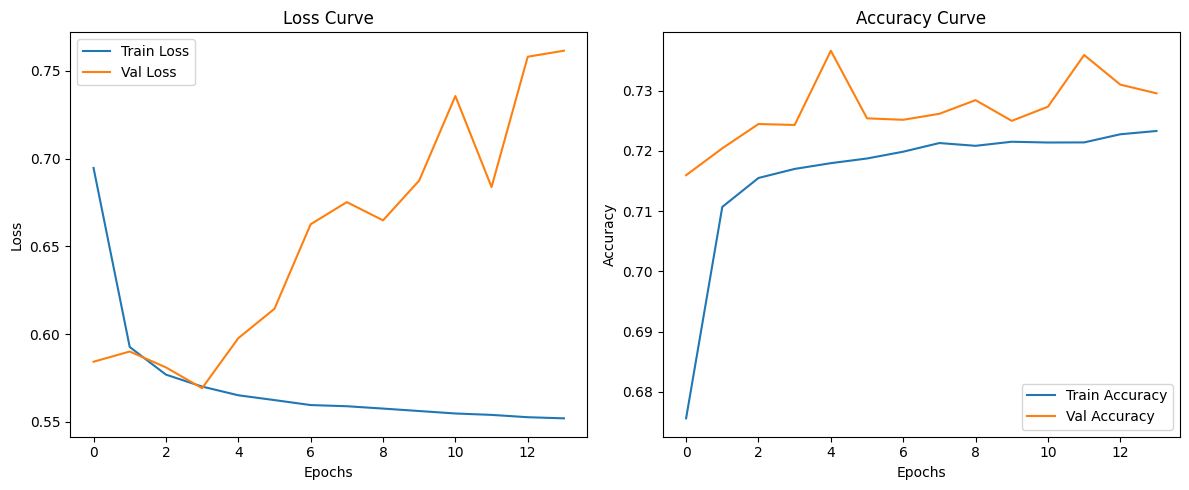

4395/4395 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Test Accuracy: 0.7253

Classification Report:
               precision    recall  f1-score   support

       BENIGN       0.99      1.00      0.99     11350
    DrDoS_DNS       0.49      0.83      0.62     12000
   DrDoS_LDAP       0.21      0.00      0.00     12000
  DrDoS_MSSQL       0.94      0.93      0.93     12000
    DrDoS_NTP       0.99      0.98      0.99     12000
DrDoS_NetBIOS       0.94      0.99      0.96     12000
   DrDoS_SNMP       0.65      0.83      0.73     12000
   DrDoS_SSDP       0.46      0.96      0.62     12000
    DrDoS_UDP       0.00      0.00      0.00     12000
          Syn       0.59      1.00      0.74     10472
         TFTP       0.96      0.99      0.98     11995
      UDP-lag       0.94      0.20      0.33     10803

     accuracy                           0.73    140620
    macro avg       0.68      0.73      0.66    140620
 weighted avg       0.68      0.73      0.66    140620



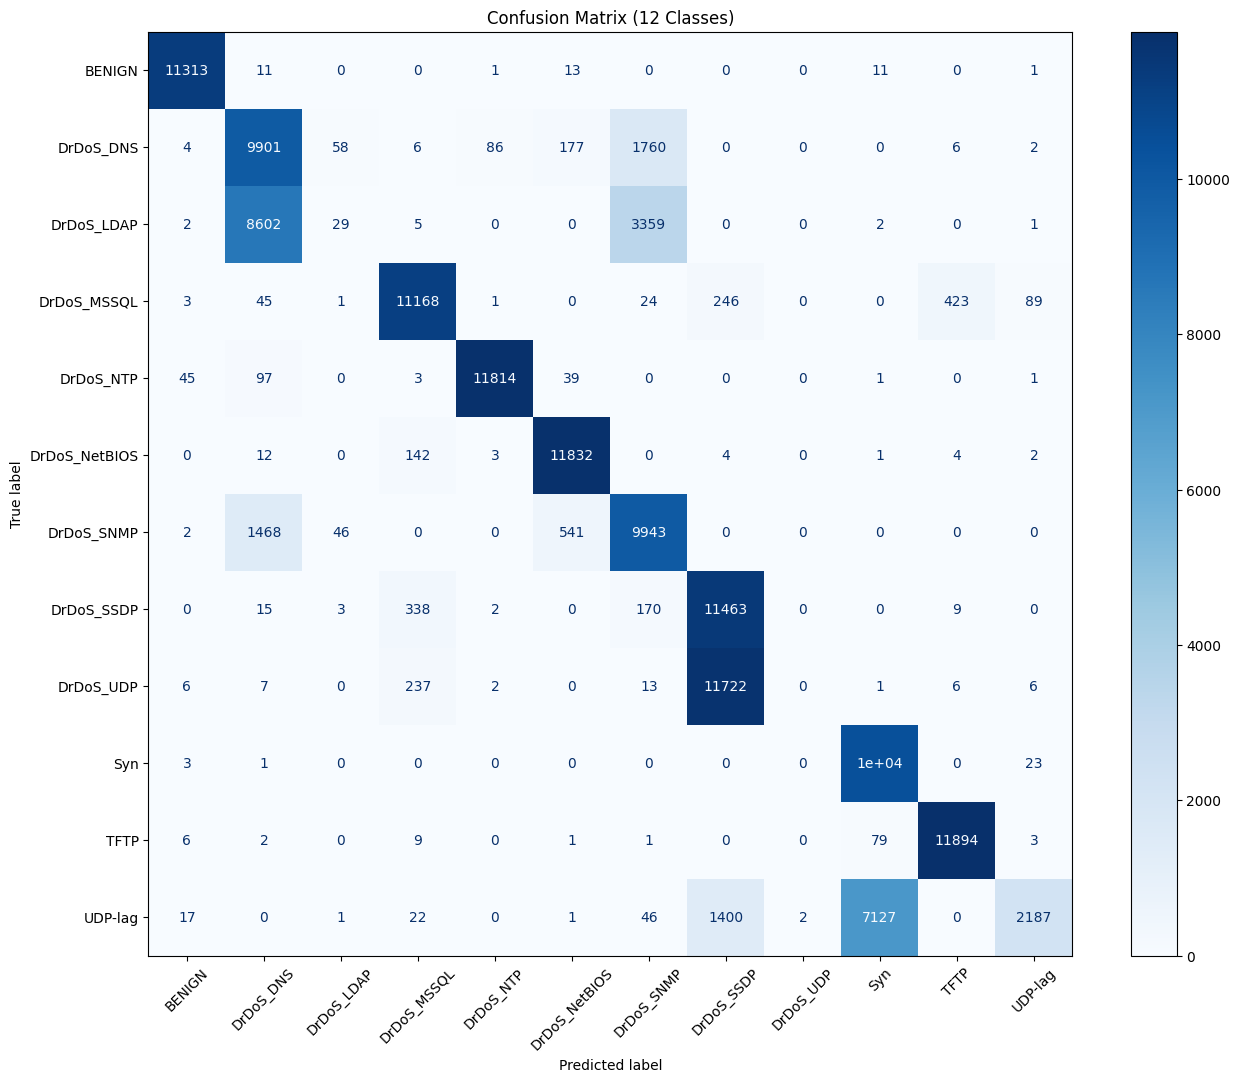

In [ ]:
#MLP

# divide data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

num_classes = len(le.classes_)
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_val_onehot = to_categorical(y_val, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

# standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

def build_mlp_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),  # 防止过拟合
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')  # 多分类输出层
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',  # 多分类损失函数
        metrics=['accuracy']
    )
    return model

# 初始化模型
input_shape = X_train_scaled.shape[1]
mlp = build_mlp_model(input_shape, num_classes)
mlp.summary()  # 打印模型结构

# 定义早停回调（防止过拟合）
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 训练模型
history = mlp.fit(
    X_train_scaled, y_train_onehot,
    validation_data=(X_val_scaled, y_val_onehot),
    epochs=200,          # 最大训练轮次
    batch_size=64,       # 批量大小
    callbacks=[early_stop],
    verbose=1
)

# 绘制训练曲线
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 预测概率
y_pred_proba = mlp.predict(X_test_scaled)
# 转换为类别标签
y_pred = np.argmax(y_pred_proba, axis=1)

# 准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# 分类报告
class_names = le.classes_.tolist()
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 混淆矩阵
fig, ax = plt.subplots(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (12 Classes)")
plt.show()

In [ ]:
kernel_explainer(x_train,x_test,mlp)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,644 (240.80 KB)

 Trainable params: 60,748 (237.30 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - accuracy: 0.6373 - loss: 0.8123 - val_accuracy: 0.7081 - val_loss: 0.5840 - learning_rate: 0.0010
Epoch 2/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.6974 - loss: 0.6184 - val_accuracy: 0.7180 - val_loss: 0.5698 - learning_rate: 0.0010
Epoch 3/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.7065 - loss: 0.5985 - val_accuracy: 0.7204 - val_loss: 0.5638 - learning_rate: 0.0010
Epoch 4/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.7088 - loss: 0.5877 - val_accuracy: 0.7210 - val_loss: 0.5548 - learning_rate: 0.0010
Epoch 5/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - accuracy: 0.7116 - loss: 0.5824 - val_accuracy: 0.7219 - val_loss: 0.5562 - learning_rate: 0.0010
Epoch 6/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - accuracy: 0.7135 - loss: 0.5757 - val_accuracy: 0.7163 - val_loss: 0.5661 - learning_rate: 0.0010
Epoch 7/200
7031/7031 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - accura

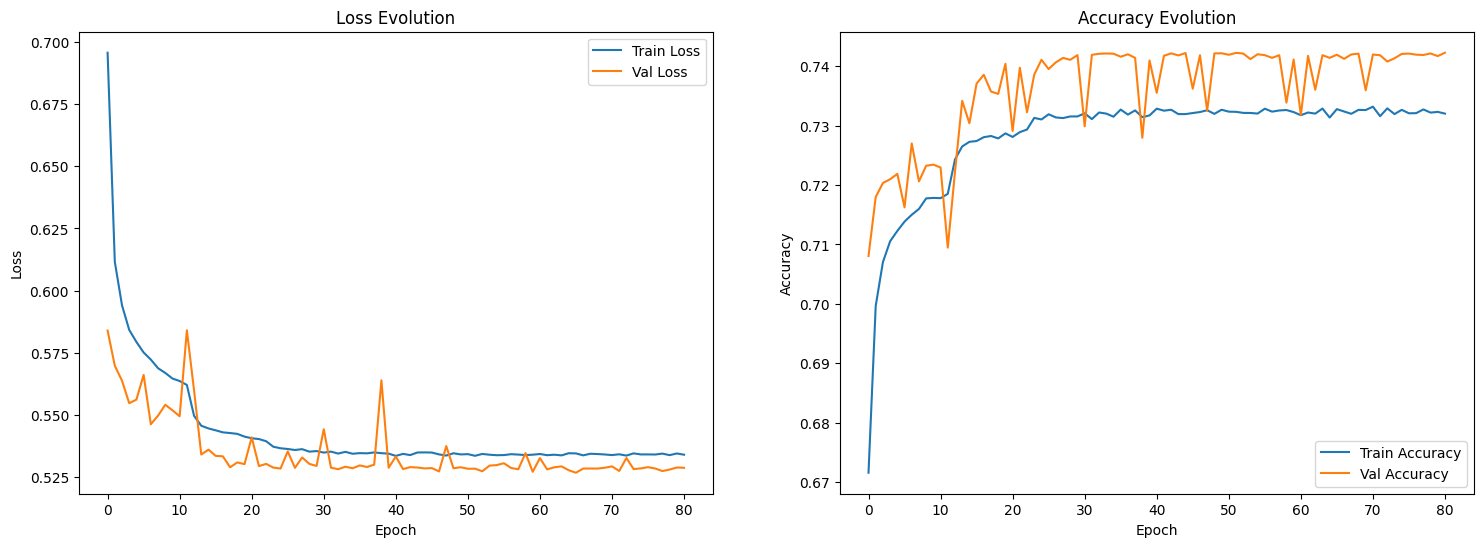

4395/4395 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step

Classification Report:
               precision    recall  f1-score   support

       BENIGN       1.00      1.00      1.00     11350
    DrDoS_DNS       0.58      0.54      0.55     12000
   DrDoS_LDAP       0.54      0.42      0.47     12000
  DrDoS_MSSQL       0.95      0.95      0.95     12000
    DrDoS_NTP       0.99      0.99      0.99     12000
DrDoS_NetBIOS       0.95      0.98      0.97     12000
   DrDoS_SNMP       0.65      0.83      0.73     12000
   DrDoS_SSDP       0.48      0.06      0.10     12000
    DrDoS_UDP       0.48      0.94      0.63     12000
          Syn       0.59      1.00      0.74     10472
         TFTP       0.97      0.99      0.98     11995
      UDP-lag       0.97      0.20      0.34     10803

     accuracy                           0.74    140620
    macro avg       0.76      0.74      0.70    140620
 weighted avg       0.76      0.74      0.71    140620



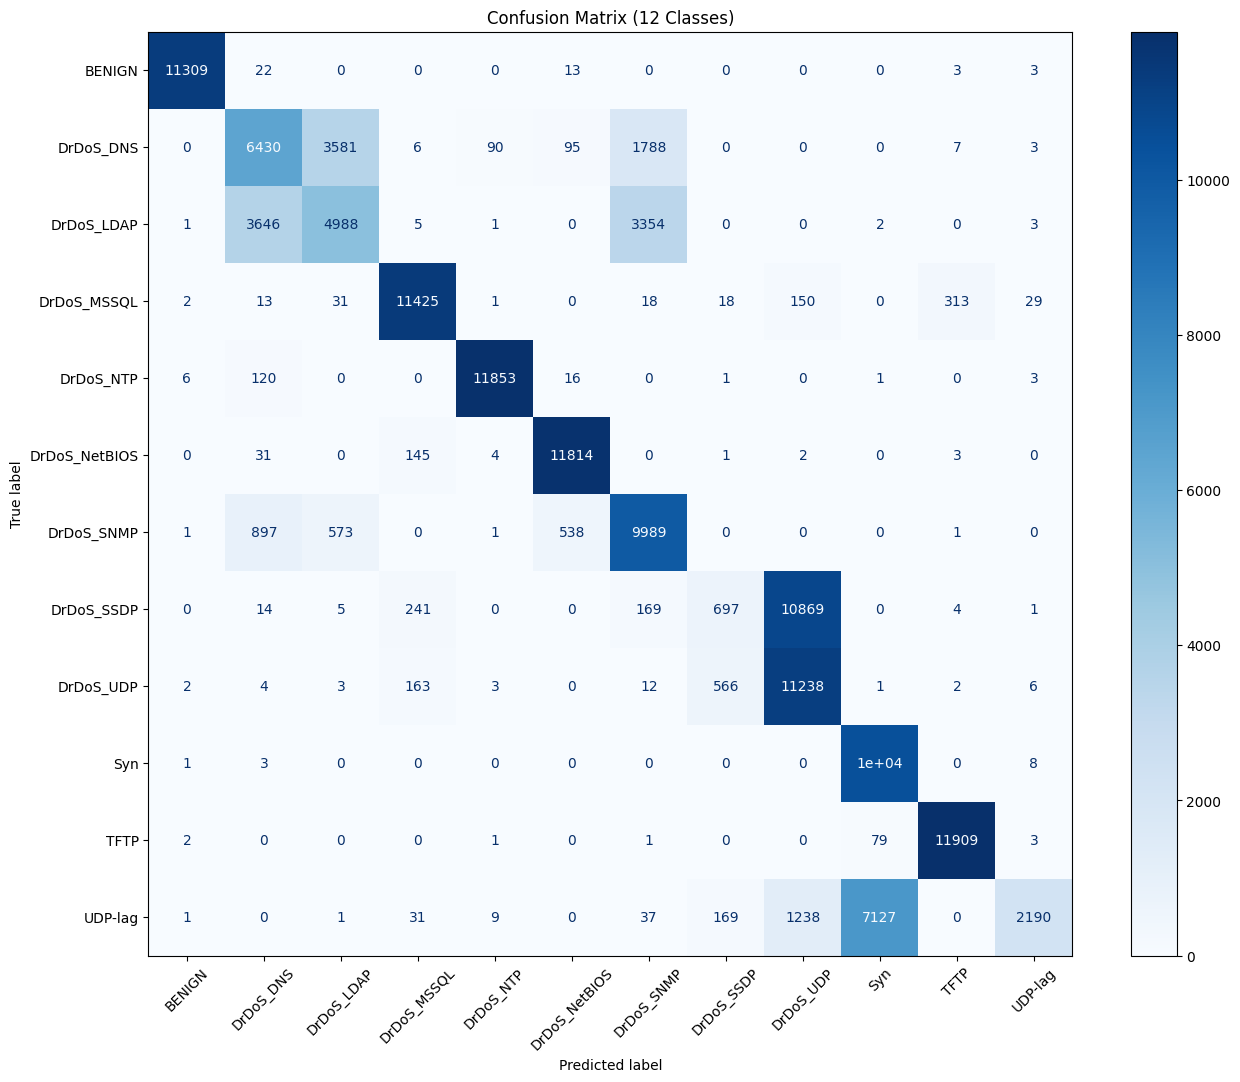


Top 10 Frequent Errors:
True_Class  Predicted_Class
DrDoS_SSDP  DrDoS_UDP          10869
UDP-lag     Syn                 7127
DrDoS_LDAP  DrDoS_DNS           3646
DrDoS_DNS   DrDoS_LDAP          3581
DrDoS_LDAP  DrDoS_SNMP          3354
DrDoS_DNS   DrDoS_SNMP          1788
UDP-lag     DrDoS_UDP           1238
DrDoS_SNMP  DrDoS_DNS            897
            DrDoS_LDAP           573
DrDoS_UDP   DrDoS_SSDP           566
Name: count, dtype: int64


In [ ]:
#DNN
# 划分训练集、验证集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 将标签转换为独热编码
num_classes = len(le.classes_)
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_val_onehot = to_categorical(y_val, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

def build_dnn_model(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')  # 多分类输出层
    ])

    # 自定义优化器
    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        weight_decay=1e-4  # L2正则化
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 初始化模型
input_shape = X_train_scaled.shape[1]
dnn = build_dnn_model(input_shape, num_classes)
dnn.summary()  # 打印模型架构

# 定义回调函数
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
]

# 训练模型
history = dnn.fit(
    X_train_scaled, y_train_onehot,
    validation_data=(X_val_scaled, y_val_onehot),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# 绘制训练曲线
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # 损失曲线
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Evolution')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # 准确率曲线
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax2.set_title('Accuracy Evolution')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

plot_history(history)

# 预测与评估
y_pred_proba = dnn.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

# 分类报告
class_names = le.classes_.tolist()
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 混淆矩阵
fig, ax = plt.subplots(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (12 Classes)")
plt.show()

# 错误样本分析
error_mask = y_pred != y_test
error_samples = X_test[error_mask]
error_true = y_test[error_mask]
error_pred = y_pred[error_mask]

error_df = pd.DataFrame({
    'True_Class': le.inverse_transform(error_true),
    'Predicted_Class': le.inverse_transform(error_pred)
})
print("\nTop 10 Frequent Errors:")
print(error_df.value_counts().head(10))

In [ ]:
deep_explainer(x_train,x_test,dnn)

[0]	validation_0-mlogloss:2.10083	validation_1-mlogloss:2.10125
[1]	validation_0-mlogloss:1.85903	validation_1-mlogloss:1.85948
[2]	validation_0-mlogloss:1.68038	validation_1-mlogloss:1.68093
[3]	validation_0-mlogloss:1.53823	validation_1-mlogloss:1.53883
[4]	validation_0-mlogloss:1.42151	validation_1-mlogloss:1.42217
[5]	validation_0-mlogloss:1.32324	validation_1-mlogloss:1.32389
[6]	validation_0-mlogloss:1.23818	validation_1-mlogloss:1.23890
[7]	validation_0-mlogloss:1.16469	validation_1-mlogloss:1.16545
[8]	validation_0-mlogloss:1.09930	validation_1-mlogloss:1.10008
[9]	validation_0-mlogloss:1.04165	validation_1-mlogloss:1.04243
[10]	validation_0-mlogloss:0.99081	validation_1-mlogloss:0.99161
[11]	validation_0-mlogloss:0.94425	validation_1-mlogloss:0.94509
[12]	validation_0-mlogloss:0.90361	validation_1-mlogloss:0.90451
[13]	validation_0-mlogloss:0.86654	validation_1-mlogloss:0.86751
[14]	validation_0-mlogloss:0.83316	validation_1-mlogloss:0.83418
[15]	validation_0-mlogloss:0.80298	

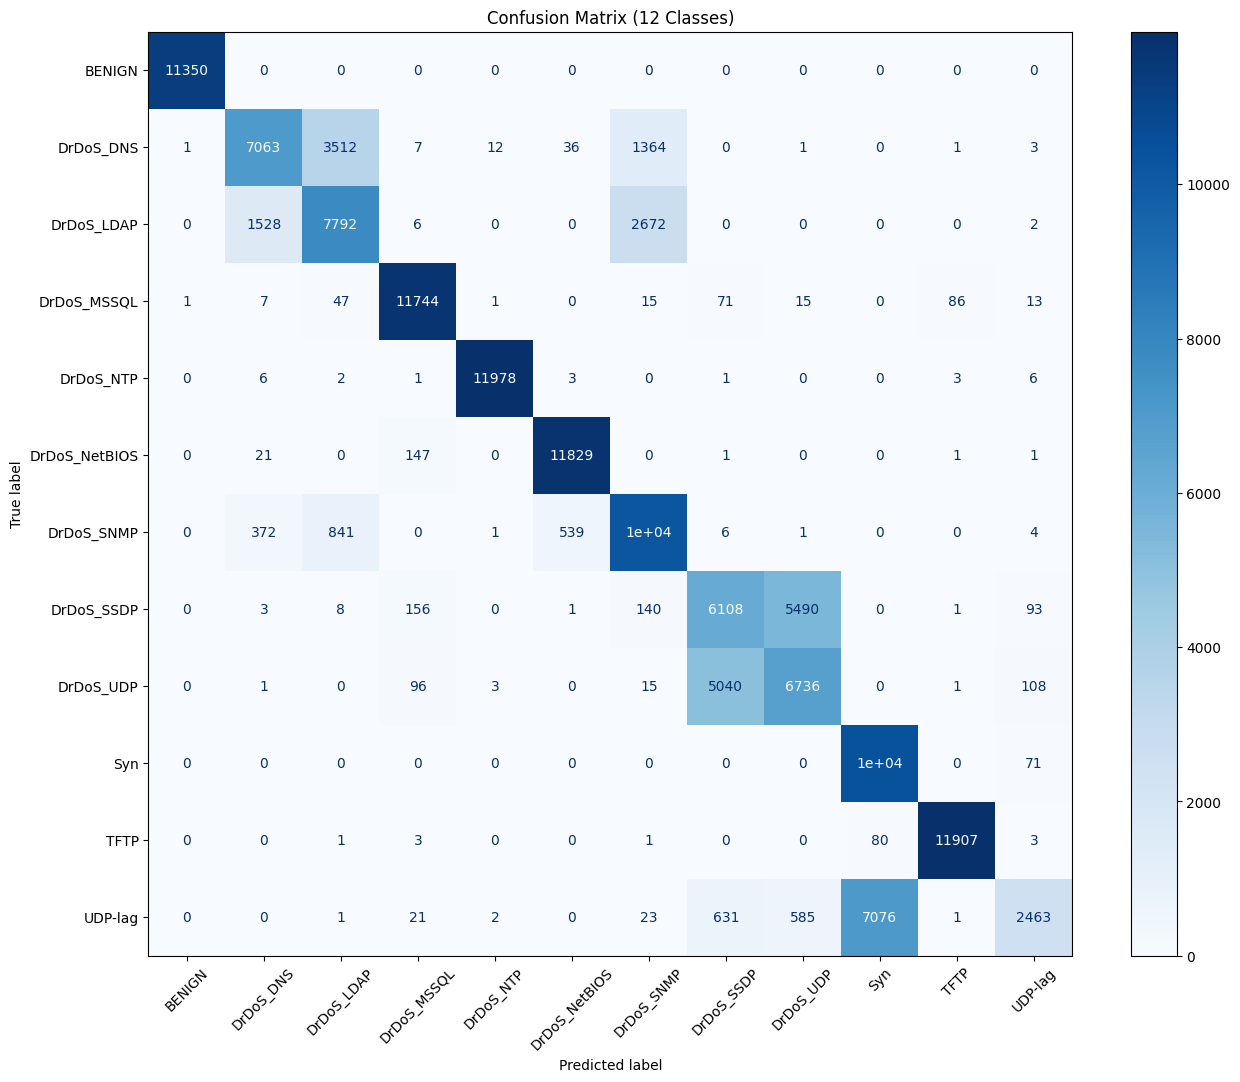

<Figure size 1200x800 with 0 Axes>

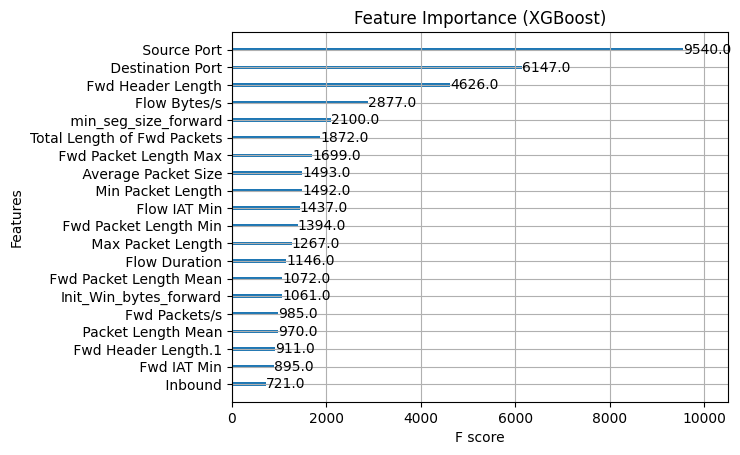

In [ ]:
#XGBoost
from xgboost import XGBClassifier, plot_importance, plot_tree

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 初始化XGBoost分类器（关键参数针对多分类）
xgb_clf = XGBClassifier(
    objective='multi:softprob',  # 多分类概率输出
    num_class=len(np.unique(y)),  # 类别数量（12类）
    learning_rate=0.1,
    n_estimators=200,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1正则化
    reg_lambda=0.1,  # L2正则化
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=20,  # 早停法
    scale_pos_weight=None  # 若存在类别不平衡需手动计算权重
)

# 训练模型
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

# 预测
y_pred = xgb_clf.predict(X_test)

# 准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# 分类报告
class_names = le.classes_.tolist()
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

fig, ax = plt.subplots(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (12 Classes)")
plt.show()

# XGBoost内置特征重要性
plt.figure(figsize=(12, 8))
plot_importance(xgb_clf, max_num_features=20)  # 显示前20个重要特征
plt.title("Feature Importance (XGBoost)")
plt.show()

In [ ]:
tree_explainer(X,xgb_clf)